In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torch.utils.data as data
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import random

use_cuda = True
device_id = 3
from tensorflow.contrib.keras.python.keras.datasets.imdb import load_data, get_word_index

max_features = 5000
batch_size = 30
epochs = 15
learning_rate = 0.001

In [11]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [3]:
(x_train, y_train), (x_test, y_test) = load_data(num_words=max_features)


In [4]:
def pad(tensor, length):
    return torch.cat([tensor, tensor.new(length - tensor.size(0),*tensor.size()[1:]).zero_()])

In [5]:
def sortedText(idx, xs, ys):
    batch_xs = xs[idx]
    batch_ys = ys[idx]
    lengths = np.array([len(x) for x in batch_xs])
    sort_idx = np.argsort(lengths)[::-1]
    return batch_xs[sort_idx], lengths[sort_idx], batch_ys[sort_idx]


def textTensor(idx, xs, ys):
    batch_xs, lengths, batch_ys = sortedText(idx, xs, ys)
    max_length = lengths[0]
    return torch.cat([pad(torch.Tensor(x), max_length).view(max_length, 1)
                      for x in batch_xs], 1).long(), list(lengths), torch.FloatTensor(batch_ys)


In [6]:
def get_last_step_indices(lengths):
    n_lengths = len(lengths)
    rev_lengths = lengths[::-1]
    rev_lengths_sum = torch.LongTensor(rev_lengths).cumsum(0)
    return torch.LongTensor([(n_lengths - i - 1) * length + rev_lengths_sum[i] - 1
                         for i, length in enumerate(rev_lengths)][::-1])


def get_last_step_tensor(packed_sequence, lengths):
    indices = Variable(torch.LongTensor(get_last_step_indices(lengths)))
    if packed_sequence.data.data.is_cuda:
        indices = indices.cuda(packed_sequence.data.data.get_device())
    last_step = packed_sequence.data.index_select(0, indices)
    return last_step

In [7]:
class IMDB_Classifier(nn.Module):
    def __init__(self, input_size, embedding_size, filters, hidden_size, batch_size, n_layers=1):
        super(IMDB_Classifier, self).__init__()
        self.n_layers = n_layers
        self.embedding_size = embedding_size
        self.filters = filters
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(0.25)
        self.conv = nn.Conv1d(embedding_size, filters, 5, stride=1, padding=0)
        self.pooling = nn.MaxPool1d(4)
        self.lstm = nn.LSTM(filters, hidden_size)
        self.dense = nn.Linear(hidden_size, 1)
        
    def forward(self, word_input, input_length, hidden=None):
        word_embedded = self.embedding(word_input)
        output = self.dropout(word_embedded)
        output = output.transpose(0, 1).transpose(1,2)
        output = F.relu(self.conv(output))
        output = self.pooling(output)
        output = output.transpose(1, 2).transpose(0, 1)
        input_length = [(i-4)/4 for i in input_length]
        output = pack_padded_sequence(output, input_length)
        output, hidden = self.lstm(output, hidden)
        output = get_last_step_tensor(output, input_length)
        output = F.sigmoid(self.dense(output))
        
        return output
        
    
    def initHidden(self):
        hidden = Variable(torch.zeros(1, self.batch_size, self.hidden_size))
        cell = Variable(torch.zeros(1, self.batch_size, self.hidden_size))
        return (hidden.cuda(device_id), cell.cuda(device_id)) if use_cuda else (hidden, cell) 

In [ ]:


clf = IMDB_Classifier(max_features, 128, 64, 70, batch_size)
clf = clf.cuda(device_id) if use_cuda else clf
optimizer = optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.BCELoss()

start = time.time()
losses_log = []
for epoch in range(1, 4):
    losses = 0
    indices = np.random.permutation(np.array(range(25000)))
    for i in range(1, indices.shape[0] / batch_size + 1):
        x, lengths, y = textTensor(indices[(i-1)*batch_size:i*batch_size], x_train, y_train)
        x, y = Variable(x), Variable(y)

        (x, y) = (x.cuda(device_id), y.cuda(device_id)) if use_cuda else (x, y)

        output = clf(x, lengths)
        loss = criterion(output, y)
        losses += loss.data[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses_log.append(losses / i)
        if i % 100 == 0:
            print("batch: {}, batch_loss: {}".format(i, losses / i))

    print("Epoch: {}, time: {}, loss: {}".format(epoch, timeSince(start, float(epoch) / epochs), losses/(i)))



    total = 0
    correct = 0
    for i in range(250):
        x, lengths, y = textTensor(range(25000)[i*100:(i+1)*100], x_train, y_train)
        #x, lengths, y = textTensor(torch.LongTensor(range(32)), x_train, y_train)
        x, y = Variable(x, volatile=True), Variable(y)
        (x, y) = (x.cuda(device_id), y.cuda(device_id)) if use_cuda else (x, y)
        output = clf(x, lengths)
        output = output > 0.5
        correct += (output.float() == y).sum().data[0]
        total += y.size(0)
    print('Accuracy of the network on the {} texts: {}%'.format(y_test.shape[0], 100. * correct / total))

batch: 100, batch_loss: 0.688246328831
batch: 200, batch_loss: 0.67787404865
batch: 300, batch_loss: 0.669855244557
batch: 400, batch_loss: 0.657552351356
batch: 500, batch_loss: 0.65127071923
batch: 600, batch_loss: 0.643693059683
batch: 700, batch_loss: 0.632252768278
batch: 800, batch_loss: 0.62206856586
Epoch: 1, time: 0m 36s (- 8m 37s), loss: 0.618592751949
Accuracy of the network on the 25000 texts: 68.792%
batch: 100, batch_loss: 0.517132448554
batch: 200, batch_loss: 0.507845344394
batch: 300, batch_loss: 0.506359163821
batch: 400, batch_loss: 0.505910730734
batch: 500, batch_loss: 0.499789999336
batch: 600, batch_loss: 0.50040731507
batch: 700, batch_loss: 0.49427968485
batch: 800, batch_loss: 0.489858071879
Epoch: 2, time: 1m 19s (- 8m 35s), loss: 0.489912014012
Accuracy of the network on the 25000 texts: 73.276%
batch: 100, batch_loss: 0.446806558073
batch: 200, batch_loss: 0.445086869895
batch: 300, batch_loss: 0.446847209583
batch: 400, batch_loss: 0.44819522243
batch: 500

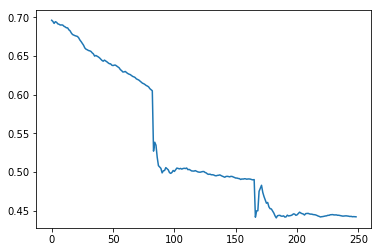

In [20]:
plt.plot(losses_log)